# OpenAi MountainCar
[Documentation](https://gymnasium.farama.org/environments/classic_control/mountain_car/)  
This environment is part of the Classic Control environments which contains general information about the environment.

## Description
The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. This version is the one with discrete actions.

## imports

In [1]:
import os
import time
import math
import gymnasium as gym
import numpy as np
import random
import imageio
from IPython.display import clear_output
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
%matplotlib inline

## Global variables

In [2]:
EPISODES = 25000
SHOW_EVERY = 2500
RANDOM_SEED = random.randint(1, 5000)
# RANDOM_SEED = 3847 # comment for a random seed
RANDOM_SEED

423

## Get env informations

In [3]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset()

print(env.observation_space.high)
print(env.observation_space.low)
print(env.state.shape[0])
print(env.action_space.n)
print(env.goal_position)

[0.6  0.07]
[-1.2  -0.07]
2
3
0.5


## Set-up the Agent

In [4]:
class Agent():
    """
    An agent class that implements the Q-learning algorithm to solve the MountainCar-v0 problem from OpenAI Gym.

    Args:
        bin_size (int): The number of discrete states for each continuous state variable. Defaults to 20.
        seed (int): The seed used to initialize the environment and numpy.random. Defaults to None.

    Attributes:
        env (gym.Env): The OpenAI Gym environment.
        seed (int): The seed used to initialize the environment and numpy.random.
        state_space (int): The number of states (Position, Velocity, Angle, Angular Velocity): 4.
        action_space (int): The number of possible actions (0, 1): 2.
        bin_size (int): The number of discrete states for each continuous state variable.
        q_table (numpy.ndarray): A matrix of dimensions (bin_size, bin_size, bin_size, bin_size, action_space) that represents the Q-Values for each state-action pair.
        discrete_os_win_size (numpy.ndarray): An array of size (state_space,) that represents the size of each bin in the discretized state space.
        epsilon (float): The exploration rate, which determines the probability of selecting a random action instead of the best action according to the Q-Values.
    """
    def __init__(self, bin_size: int = 20, seed: int = None):
        """
        Initialize the agent.

        Args:
            bin_size (int): The number of discrete states for each continuous state variable. Defaults to 20.
            seed (int): The seed used to initialize the environment and numpy.random. Defaults to None.
        """
        self.env = gym.make("MountainCar-v0", render_mode="rgb_array")
        self.seed = seed
        if self.seed:
            self.env.action_space.seed(self.seed)
            np.random.seed(self.seed)

        # initialize environment
        self.reset()
        self.state_space = self.env.state.shape[0] # number of states (Position, Velocity, Angle, Angular Velocity): 4
        self.action_space = self.env.action_space.n # number of possible actions (0, 1): 2
        self.bin_size = bin_size
        self.q_table, self.discrete_os_win_size = self.Qtable()
        
        # Epsilon
        self.epsilon = 0.5
    
    def reset(self):
        """
        Reset the environment and return the initial state.

        Returns:
            numpy.ndarray: The initial state.
        """
        if self.seed:
            return self.env.reset(seed=self.seed)
        else:
            return self.env.reset()

    def __get_last(self, l):
        """
        Return the last element of a list, or None if the list is empty.

        Args:
            l (list): The list.

        Returns:
            any: The last element of the list, or None if the list is empty.
        """
        return None if len(l) <= 0 else l[-1]
    
    def Qtable(self):
        """
        Create a matrix of Q-Values and an array of bin sizes for the discretized state space.

        Returns:
            Tuple[numpy.ndarray, numpy.ndarray]: The Q-Values matrix and the bin size array.
        """
        high = env.observation_space.high
        low = env.observation_space.low
        
        discrete_os_size = [self.bin_size] * self.state_space
        discrete_os_win_size = (high - low) / discrete_os_size
        
        q_table = np.random.uniform(low=-2, high=0, size=(discrete_os_size + [self.action_space]))
        return q_table, discrete_os_win_size
    
    def get_discrete(self, state):
        """
        Transform a continuous state into a discrete one

        Args:
        state (np.ndarray): Array of the continuous state.

        Returns:
        discrete_state (tuple): Tuple with the indices of the bins that the continuous state belongs to.
        """
        low = env.observation_space.low
        discrete_state = (state - low) / self.discrete_os_win_size
        return tuple(discrete_state.astype(np.int64))
    
    def policy(self, state: tuple):
        """
        Determines the optimal action for a given state based on the Q-Table

        Args:
        state (tuple): Discrete state of the environment.

        Returns:
        action (int): Optimal action for the given state.
        """
        return np.argmax(self.q_table[state])
    
    def new_Q_value(self, reward: float, new_state: tuple, gamma = 0.95) -> float:
        """
        Calculate the new Q-value for a given state and action pair based on the Bellman equation
    
        Args:
        reward (float): Reward for the transition.
        new_state (tuple): New state reached after performing the action.
        gamma (float): Discount factor for future rewards. Default is 0.95.

        Returns:
        learned_value (float): Updated Q-value.
        """
        # Maximum possible QValue in the next step
        max_future_q = np.max(self.q_table[new_state])
        learned_value = reward + gamma * max_future_q
        return learned_value
    
    def learning_rate(self) -> float:
        """
        Returns the learning rate for the Q-learning algorithm.

        Returns:
        alpha (float): Learning rate.
        """
        return 0.1
    
    def update_exploration_rate(self, episode: int) -> float:
        """
        Update the exploration rate (epsilon) for the epsilon-greedy policy
    
        Args:
        episode (int): Current episode number.

        Returns:
        epsilon (float): Updated exploration rate.
        """
        start_epsilon_decaying = 1
        end_epsilon_decaying = EPISODES // 2
        epsilon_decay_value = self.epsilon / (end_epsilon_decaying - start_epsilon_decaying)
        if end_epsilon_decaying >= episode >= start_epsilon_decaying:
            self.epsilon -= epsilon_decay_value
    
    def fit(self, episodes = 2000):
        """
        Trains the agent for a specified number of episodes.
        
        Parameters:
            episodes (int): Number of episodes to train the agent. Default is 2000.
            
        Returns:
            Tuple: A tuple containing the list of rewards and a dictionary with aggregated episode rewards.
        """
        rewards = []
        aggr_ep_rewards = {'ep': [], 'avg': [], 'min': [], 'max': []}
        solved = 0

        for episode in range(episodes):
            print(f"{episode + 1}/{episodes} : sloved=({solved} => {int(solved * 100 / (episode+1))}%) | avg: {self.__get_last(aggr_ep_rewards['avg'])} min: {self.__get_last(aggr_ep_rewards['min'])} max: {self.__get_last(aggr_ep_rewards['max'])}", end="\r")
            
            # episode initialization 
            discrete_state = self.get_discrete(self.reset()[0])
            score = 0
            step = 0
            done = False

            # learning loop for the current episode
            while not done:
                # action selection
                if np.random.random() > self.epsilon:
                    action = self.policy(discrete_state) # policy action
                else:
                    action = self.env.action_space.sample() # random action

                # increment environment
                observation, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated
                next_state = self.get_discrete(observation)
                score += reward

                # If the simulation did not end - updating Q table
                if not done:
                    # learning from environnement
                    lr = self.learning_rate()
                    learnt_value = self.new_Q_value(reward, next_state)
                    # Current Qvalue for the current state and selected action
                    current_q = self.q_table[discrete_state + (action, )]
                    # QLearning equation to calculate the new Qvalue
                    new_q = (1-lr) * current_q + lr * learnt_value
                    # Updating Qtable
                    self.q_table[discrete_state + (action, )] = new_q

                # if simulation ended and goal position is achived
                elif observation[0] >= self.env.goal_position:
                    self.q_table[discrete_state + (action, )] = 0
                    # End of the episode update
                    solved += 1   
                
                discrete_state = next_state
                
                step += 1
                
            # Updating epsilon rate
            self.update_exploration_rate(episode)

            rewards += [score]
            if not episode % SHOW_EVERY:
                average_reward = sum(rewards[-SHOW_EVERY:])/len(rewards[-SHOW_EVERY:])
                aggr_ep_rewards['ep'] += [episode]
                aggr_ep_rewards['avg'] += [average_reward]
                aggr_ep_rewards['min'] += [min(rewards[-SHOW_EVERY:])]
                aggr_ep_rewards['max'] += [max(rewards[-SHOW_EVERY:])]


        self.env.close()
        print("\nEnd")
        return rewards, aggr_ep_rewards
    
    def render(self):
        """
        Renders the environment using a policy and saves a gif of the simulation.
        """
        # Initialize the image to render the environment
        img = plt.imshow(self.env.render())
        # Get the initial state and discretize it
        current_state = self.get_discrete(self.env.reset()[0])
        # Run the simulation for 1000 steps
        for t in range(1000):
            # Get the action to take from the current state using the policy
            action = self.policy(current_state)
            # Perform the action in the environment
            observation, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            # Update the image and display it
            img.set_data(self.env.render())
            plt.axis('off')
            plt.suptitle(f"Timestep=({t})")
            display.display(plt.gcf())
            clear_output(wait=True)
            # Check if the simulation is done
            if done:
                observation, info = self.reset()
                break
            else:
                # Discretize the new observation and update the current state
                current_state = self.get_discrete(observation)
        # Close the environment
        self.env.close()
    
    def __update_plot(self, frame_number, current_state, num_iteration):
        """
        Private method to update the plot for each frame of the gif.
        """
        # Take an action according to the policy
        action = self.policy(current_state)
        # Perform the action and get the observation, reward, and done signal
        observation, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        # Get the new state of the environment
        state = self.env.render()

        # converting state to plot in order to stylize it
        fig = Figure()
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(1,1,1)
        ax.imshow(state)
        ax.axis('off')
        ax.set_title(f"Timestep=({frame_number})")
        canvas.draw()

        # reconverting plot to state
        size = fig.get_size_inches() * fig.dpi
        image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(size[1]), int(size[0]), 3)

        # Reset the environment if done signal is True
        if done:
            observation, info = self.reset()
            num_iteration -= 1
            time.sleep(0.5)
            frame_number = 0
        else:
            # Discretize the new observation and update the current state and frame number
            current_state = self.get_discrete(observation)
            frame_number += 1
        return image, frame_number, current_state, num_iteration
    
    def save(self):
        """
        Saves a gif of the simulation.
        """
        # Get the initial state and render it
        current_state = self.get_discrete(self.reset()[0])
        frame = self.env.render()
        # Initialize the number of iterations and frames
        num_iteration = 5
        images = []
        frame_number = 0
        # Run the simulation for num_iteration iterations
        while num_iteration > 0:
            print(f"{(5 - num_iteration)+1}/{5}", end="\r")
            # Update the plot and append the resulting image to images
            frame, frame_number, current_state, num_iteration = self.__update_plot(frame_number, current_state, num_iteration)
            images.append(Image.fromarray(frame))
        # Save the images as a gif
        print("\nSaving..............", end="\r")     
        images[0].save('img/mountain_car.gif', format='GIF', save_all=True, append_images=images[1:], duration=50, loop=0)
        print("Saved                   ")

In [5]:
agent_argmax = Agent(bin_size=40)
rewards_argmax, aggr_ep_rewards_argmax = agent_argmax.fit(episodes = EPISODES)

25000/25000 : sloved=(16540 => 66%) | avg: -160.4944 min: -200.0 max: -103.0
End


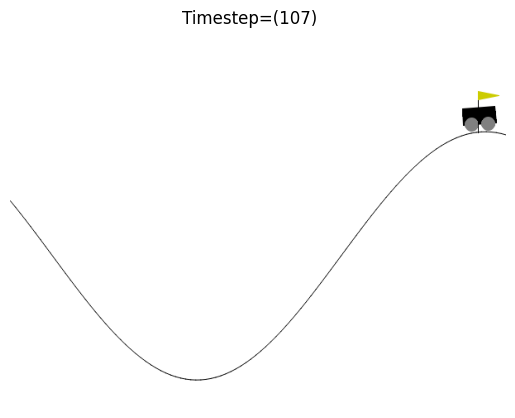

In [6]:
agent_argmax.render()

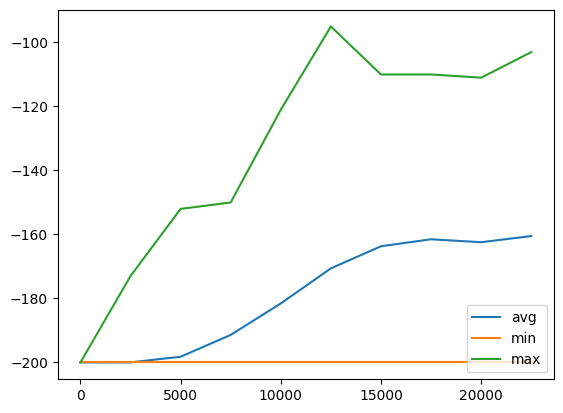

In [7]:
plt.plot(aggr_ep_rewards_argmax['ep'], aggr_ep_rewards_argmax['avg'], label="avg")
plt.plot(aggr_ep_rewards_argmax['ep'], aggr_ep_rewards_argmax['min'], label="min")
plt.plot(aggr_ep_rewards_argmax['ep'], aggr_ep_rewards_argmax['max'], label="max")
plt.legend(loc=4)
plt.show()

## Save

In [8]:
agent_argmax.save()

5/5
Saved                   
